In [22]:
"""
Assignment 3 - clustering
"""
from collections import Counter
import time
import sys
import pdb
sys.path.append("C:\\users\\mccar\\miniconda3\\lib\\site-packages")
import numpy as np
import pandas as pd
import os
import warnings
import umap
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, silhouette_score, mutual_info_score, mean_squared_error
from sklearn.model_selection import validation_curve, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE
from scipy.stats import kurtosis
from sklearn.metrics import pairwise_distances
from sklearn.manifold import trustworthiness
from keras.models import Sequential
from keras.layers import Dense, Flatten
# from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, Callback


In [23]:
# pd.set_option('display.max_columns', 60)
train_df = pd.read_csv("data/gtzan/features_3_sec.csv")
train_df.head()
# print(train_df.shape)
# print(train_df.info())

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [24]:
# Preprocessing
train_df = train_df.drop(['filename', 'length'], axis = 1)
y = train_df['label']
X = train_df.drop('label', axis = 1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# More preprocessing
scale = MinMaxScaler()
scaled_data = scale.fit_transform(x_train)
x_train_sc = pd.DataFrame(scaled_data, columns = x_train.columns).values
scaled_data = scale.fit_transform(x_test)
x_test_sc = pd.DataFrame(scaled_data, columns = x_test.columns).values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.fit_transform(y_test)

In [26]:
# K Means

run = False
if run:
    # Define the range of cluster numbers (K)
    k_range = range(2, 15)

    # Plotting the clustering results for varying numbers of clusters
    silhouette_scores = []
    wcss = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(x_train_sc)
        labels = kmeans.labels_
        wcss.append(kmeans.inertia_)
        # score = silhouette_score(x_train_sc, labels)
        # silhouette_scores.append(score)

    # Plot the silhouette scores vs. K
    plt.plot(k_range, wcss, marker='o')
    plt.title('KMeans GTZAN - WCSS vs. Number of Clusters (K)')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Within Cluster Sum of Squares')
    plt.xticks(k_range)
    plt.grid(True)
    plt.savefig("pngs/gtzan/kmeans_wcss.png")
    plt.show()

In [27]:
#TODO Analyze which clusters at 8 are overlapping and silhoette

In [28]:
# Expectation Maximation (EM) Clustering

run = False
if run:
    # Define the range of cluster numbers (K)
    k_range = range(2, 15)

    # Calculate silhouette scores for different values of K
    silhouette_scores = []
    log_likelihoods = []
    for k in k_range:
        gmm = GaussianMixture(n_components=k)
        gmm.fit(x_train_sc)
        log_likelihoods.append(gmm.score(x_train_sc))
        # labels = gmm.predict(x_train_sc)
        # silhouette_avg = silhouette_score(x_train_sc, labels)
        # silhouette_scores.append(silhouette_avg)

    # Plot the silhouette scores vs. K
    plt.plot(k_range, log_likelihoods, marker='o')
    plt.title('GTZAN Log Likelihood vs. Number of Clusters (K) EM')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Log Likelihood')
    plt.xticks(k_range)
    plt.grid(True)
    plt.savefig("pngs/gtzan/em_loglike.png")
    plt.show()

In [29]:
# PCA

# Fit PCA to the data
run = False
if run:
    pca = PCA()
    pca.fit(x_train_sc)
    x_pca = pca.fit_transform(x_train_sc)

    # Get the explained variance (eigenvalues) for each principal component
    eigenvalues = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(eigenvalues)
    print(eigenvalues)
    print(sum(eigenvalues))
    print(len(eigenvalues))

    # Plotting
    fig, ax1 = plt.subplots()

    # Bar plot for explained variance
    ax1.bar(np.arange(len(eigenvalues)), eigenvalues, color='b', alpha=0.5)
    ax1.set_xlabel('Principal Components')
    ax1.set_ylabel('Explained Variance Ratio', color='b')

    # Line plot for cumulative explained variance
    ax2 = ax1.twinx()
    ax2.plot(np.arange(len(cumulative_explained_variance)), cumulative_explained_variance, color='r')
    ax2.set_ylabel('Cumulative Explained Variance Ratio', color='r')

    plt.title('GTZAN PCA Analysis')
    plt.savefig("pngs/gtzan/pca_analysis.png")
    plt.show()

    # Plot the original clusters with colors
    plt.figure(figsize=(10, 6))
    plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y_encoded, cmap='viridis', alpha=0.5)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('GTZAN PCA Components with Colored Clusters')
    plt.colorbar(label='Cluster')
    plt.grid(True)
    plt.savefig("pngs/gtzan/pca_2d.png")
    plt.show()

    # Plot the original clusters with colors in 3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=y_encoded, cmap='viridis', alpha=0.5)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title('GTZAN PCA Components with Colored Clusters')
    plt.savefig("pngs/gtzan/pca_3d.png")
    plt.show()

In [30]:
# ICA
run = False
if run:
    # Fit ICA to the data
    ica = FastICA(n_components=2)
    x_ica = ica.fit_transform(x_train_sc)
    
    # Get the independent components
    components = ica.components_

    # Plot the original clusters with colors
    plt.figure(figsize=(10, 6))
    plt.scatter(x_ica[:, 0], x_ica[:, 1], c=y_encoded, cmap='viridis', alpha=0.5)
    plt.xlabel('Independent Component 1')
    plt.ylabel('Independent Component 2')
    plt.title('GTZAN ICA Components with Colored Clusters')
    plt.colorbar(label='Cluster')
    plt.grid(True)
    plt.savefig("pngs/gtzan/ica_2d.png")
    plt.show()

    # Fit ICA to the data
    ica = FastICA(n_components=3)
    x_ica = ica.fit_transform(x_train_sc)
    
    # Get the independent components
    components = ica.components_
    # Plot the original clusters with colors in 3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_ica[:, 0], x_ica[:, 1], x_ica[:, 2], c=y_encoded, cmap='viridis', alpha=0.5)
    ax.set_xlabel('Independent Component 1')
    ax.set_ylabel('Independent Component 2')
    ax.set_zlabel('Independent Component 3')
    ax.set_title('GTZAN ICA Components with Colored Clusters')
    plt.savefig("pngs/gtzan/ica_3d.png")
    plt.show()


    kurts = []
    max_comp = 65
    for k in range(2, max_comp):
        ica = FastICA(n_components=k, random_state=42)
        ica.fit(x_train_sc)
        x_ica = ica.transform(x_train_sc)
        kurts.append(sum(kurtosis(x_ica)))
    print(kurts)
    plt.plot(range(2, max_comp), kurts, marker='o')
    plt.title('GTZAN Kurtosis vs. Number of Independent Components (ICA)')
    plt.xlabel('Number of Independent Components')
    plt.ylabel('Kurtosis')
    plt.grid(True)
    plt.savefig("pngs/gtzan/ica_kurtosis.png")
    plt.show()

    kurtosis_quest = True
    if kurtosis_quest:
        def negentropy(x):
            return -np.sum(np.log(np.cosh(x))) - np.sum(np.log(np.sqrt(2 * np.pi * np.exp(1))))

        # Compare before and after transformation
        # 1. Mutual Information (for original data)
        mutual_info_matrix_original = np.zeros((x_train_sc.shape[1], x_train_sc.shape[1]))
        for i in range(x_train_sc.shape[1]):
            for j in range(x_train_sc.shape[1]):
                mutual_info_matrix_original[i, j] = mutual_info_score(x_train_sc[:, i], x_train_sc[:, j])

        # 2. Kurtosis (for original data)
        feature_kurtosis_original = kurtosis(x_train_sc)

        # 3. Calculate negentropy for each feature in the original data
        negentropy_original_values = np.apply_along_axis(negentropy, axis=0, arr=x_train_sc)
    
        # Apply Independent Component Analysis (ICA)
        ica = FastICA(random_state=42)
        ica.fit(x_train_sc)
        # Transform the original data using ICA
        ica_components = ica.transform(x_train_sc)

        # 3. Measures of Non-Gaussianity (Negentropy using ICA)
        # Calculate negentropy for each independent component obtained through ICA
        negentropy_values_transformed = np.apply_along_axis(negentropy, axis=0, arr=ica_components)

        # 4. Mutual Information (for transformed data)
        mutual_info_matrix_transformed = np.zeros((ica_components.shape[1], ica_components.shape[1]))
        for i in range(ica_components.shape[1]):
            for j in range(ica_components.shape[1]):
                mutual_info_matrix_transformed[i, j] = mutual_info_score(ica_components[:, i], ica_components[:, j])

        # 5. Kurtosis (for transformed data)
        component_kurtosis_transformed = kurtosis(ica_components)

In [31]:
run = False
if run:
    print("Before Transformation:")
    print("Mean Mutual Information:  {}".format(np.mean(mutual_info_matrix_original)))
    print("Mean Kurtosis:           {}".format(np.mean(feature_kurtosis_original)))
    print("Mean Negentropy:         {}".format(np.mean(negentropy_original_values)))
    
    print("After Transformation:")
    print("Mean Mutual Information:  {}".format(np.mean(mutual_info_matrix_transformed)))
    print("Mean Kurtosis:           {}".format(np.mean(component_kurtosis_transformed)))
    print("Mean Negentropy:         {}".format(np.mean(negentropy_values_transformed)))

In [32]:
# RCA

run = False
if run:
    grp = GaussianRandomProjection(n_components=2, random_state=42)
    x_rc = grp.fit_transform(x_train_sc)
    # Plot the original clusters with colors
    plt.figure(figsize=(10, 6))
    plt.scatter(x_rc[:, 0], x_rc[:, 1], c=y_encoded, cmap='viridis', alpha=0.5)
    plt.xlabel('Random Component 1')
    plt.ylabel('Random Component 2')
    plt.title('GTZAN RCA Components with Colored Clusters')
    plt.colorbar(label='Cluster')
    plt.grid(True)
    plt.savefig("pngs/gtzan/rca_2d.png")
    plt.show()

    # Plot the original clusters with colors in 3D
    grp = GaussianRandomProjection(n_components=3, random_state=42)
    x_rc = grp.fit_transform(x_train_sc)
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_rc[:, 0], x_rc[:, 1], x_rc[:, 2], c=y_encoded, cmap='viridis', alpha=0.5)
    ax.set_xlabel('Random Component 1')
    ax.set_ylabel('Random Component 2')
    ax.set_zlabel('Random Component 3')
    ax.set_title('GTZAN RCA Components with Colored Clusters')
    plt.savefig("pngs/gtzan/rca_3d.png")
    plt.show()

In [33]:
# Perform Random Component Analysis (RCA)
run = False
if run:
    r_error = []
    max_comp = 60
    for k in range(2, max_comp):
        rca = GaussianRandomProjection(n_components=k, random_state=42)
        X_rca = rca.fit_transform(x_train_sc)
        X_reconstructed = rca.inverse_transform(X_rca)
        reconstruction_error = mean_squared_error(x_train_sc, X_reconstructed)
        # print("Reconstruction error:", reconstruction_error)
        r_error.append(reconstruction_error)

    plt.plot(range(2, max_comp), r_error, marker='o')
    plt.title('GTZAN Reconstruction Error vs. Number of Components (RCA)')
    plt.xlabel('Number of Components')
    plt.ylabel('Reconstruction Error')
    plt.grid(True)
    plt.savefig("pngs/gtzan/rca_reconstruction_error.png")
    plt.show()

In [34]:
# UMAP

# Perform t-SNE
run = False
if run:
    # Perform UMAP for dimensionality reduction
    # umap_model = umap.UMAP(n_components=2, random_state=42)
    # X_umap = umap_model.fit_transform(x_train_sc)
    # # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(x_train_sc)

    # # Plot the result
    plt.figure(figsize=(8, 6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_encoded, cmap=plt.cm.get_cmap("viridis", 10))
    plt.colorbar(ticks=range(3), label='Classes')
    plt.title('t-SNE Visualization of GTZAN Dataset')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True)
    plt.savefig("pngs/gtzan/t-SNE_2d.png")
    plt.show()

    # Perform UMAP for dimensionality reduction
    # umap_model = umap.UMAP(n_components=3, random_state=42)
    # X_umap = umap_model.fit_transform(x_train_sc)
    # # Perform t-SNE
    tsne = TSNE(n_components=3, random_state=42)
    X_tsne = tsne.fit_transform(x_train_sc)

    # # Plot the result
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=y_encoded, cmap=plt.cm.get_cmap("viridis", 10))
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')
    ax.set_zlabel('t-SNE Dimension 3')
    ax.set_title('t-SNE Visualization of GTZAN Dataset')
    plt.savefig("pngs/gtzan/t-SNE_3d.png")
    plt.show()

run = False
if run:
    max_comp = 15
    # Calculate pairwise distances in the original space
    distances_original = pairwise_distances(x_train_sc, metric='euclidean')
    # Define the range of components
    component_range = np.arange(2, max_comp)
    # Initialize lists to store scores
    trustworthiness_scores = []
    continuity_scores = []
    start_time = time.time()
    
    # Iterate over different numbers of components
    for n_components in component_range:
        # Perform t-SNE with the current number of components
        umap_model = umap.UMAP(n_components=n_components, random_state=42)
        X_umap = umap_model.fit_transform(x_train_sc)
        # tsne = TSNE(n_components=n_components, random_state=42)
        # X_tsne = tsne.fit_transform(x_train_sc)
        
        # Calculate pairwise distances in the t-SNE embedding
        distances_tsne = pairwise_distances(X_umap, metric='euclidean')
        
        # Calculate trustworthiness
        trustworthiness_score = trustworthiness(distances_original, distances_tsne, n_neighbors=5)
        trustworthiness_scores.append(trustworthiness_score)
        
        execution_time = time.time() - start_time
        # Print out the execution time
        print("Execution time:", execution_time, "seconds")
        print("Trustworthiness score:", trustworthiness_score)
        
        # Calculate continuity manually
        # sorted_indices_original = np.argsort(distances_original, axis=1)[:, 1:6]  # Exclude self-distances
        # sorted_indices_tsne = np.argsort(distances_tsne, axis=1)[:, 1:6]  # Exclude self-distances
        # continuity_score = np.mean(np.in1d(sorted_indices_original, sorted_indices_tsne))
        # continuity_scores.append(continuity_score)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(component_range, trustworthiness_scores, label='Trustworthiness', marker='o')
    # plt.plot(component_range, continuity_scores, label='Continuity', marker='o')
    plt.title('GTZAN Trustworthiness of UMAP Embedding')
    plt.xlabel('Number of Components')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.savefig("pngs/gtzan/umap_scores.png")
    plt.show()
    

In [35]:
# PCA KMeans

run = False
if run:
    pca = PCA(n_components=6)
    # pca.fit(x_train_sc)
    x_pca = pca.fit_transform(x_train_sc)
    # Define the range of cluster numbers (K)
    k_range = range(2, 15)

    print(x_pca[:5])

    # Plotting the clustering results for varying numbers of clusters
    silhouette_scores = []
    wcss = []
    accuracies = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(x_pca)
        labels = kmeans.labels_
        wcss.append(kmeans.inertia_)
        
        # Find the most frequent label within each cluster
        cluster_labels = {}
        for cluster in range(k):
            cluster_labels[cluster] = Counter(y_train[labels == cluster]).most_common(1)[0][0]
        
        # Assign the most frequent label to all data points within each cluster
        assigned_labels = [cluster_labels[cluster] for cluster in labels]
        
        # Calculate accuracy using assigned labels
        accuracy = accuracy_score(y_train, assigned_labels)
        accuracies.append(accuracy)

    # Plotting
    fig, ax1 = plt.subplots()

    # Plot WCSS
    color = 'tab:blue'
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Within Cluster Sum of Squares', color=color)
    ax1.plot(k_range, wcss, marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(k_range, accuracies, marker='s', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Add title and grid
    plt.title('PCA KMeans GTZAN - WCSS and Accuracy vs. Number of Clusters (K)')
    plt.xticks(k_range)
    plt.grid(True)

    # Save and show plot
    plt.savefig("pngs/gtzan/pca_kmeans_wcss_accuracy.png")
    plt.show()

In [36]:
# PCA EM

run = False
if run:
    pca = PCA(n_components=6)
    # pca.fit(x_train_sc)
    x_pca = pca.fit_transform(x_train_sc)
    # Define the range of cluster numbers (K)
    k_range = range(2, 15)

   # Calculate silhouette scores for different values of K
    silhouette_scores = []
    log_likelihoods = []
    accuracies = []
    for k in k_range:
        gmm = GaussianMixture(n_components=k)
        gmm.fit(x_pca)
        log_likelihoods.append(gmm.score(x_pca))
        labels = gmm.predict(x_pca)
        # silhouette_avg = silhouette_score(x_train_sc, labels)
        # silhouette_scores.append(silhouette_avg)

        # Find the most frequent label within each cluster
        cluster_labels = {}
        for cluster in range(k):
            cluster_labels[cluster] = Counter(y_train[labels == cluster]).most_common(1)[0][0]
        
        # Assign the most frequent label to all data points within each cluster
        assigned_labels = [cluster_labels[cluster] for cluster in labels]
        
        # Calculate accuracy using assigned labels
        accuracy = accuracy_score(y_train, assigned_labels)
        accuracies.append(accuracy)

    # Plotting
    fig, ax1 = plt.subplots()

    # Plot WCSS
    color = 'tab:blue'
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Log Likelihood', color=color)
    ax1.plot(k_range, log_likelihoods, marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(k_range, accuracies, marker='s', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Add title and grid
    plt.title('PCA EM GTZAN - Log Likelihood and Accuracy vs. Number of Clusters (K)')
    plt.xticks(k_range)
    plt.grid(True)

    # Save and show plot
    plt.savefig("pngs/gtzan/pca_em_loglike_accuracy.png")
    plt.show()

In [37]:
# ICA KMeans

run = False
if run:
    ica = FastICA(n_components=53)
    x_ica = ica.fit_transform(x_train_sc)

    # Define the range of cluster numbers (K)
    k_range = range(2, 15)

    # Plotting the clustering results for varying numbers of clusters
    silhouette_scores = []
    wcss = []
    accuracies = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(x_ica)
        labels = kmeans.labels_
        wcss.append(kmeans.inertia_)
        # score = silhouette_score(x_train_sc, labels)
        # silhouette_scores.append(score)

            # Find the most frequent label within each cluster
        cluster_labels = {}
        for cluster in range(k):
            cluster_labels[cluster] = Counter(y_train[labels == cluster]).most_common(1)[0][0]
        
        # Assign the most frequent label to all data points within each cluster
        assigned_labels = [cluster_labels[cluster] for cluster in labels]
        
        # Calculate accuracy using assigned labels
        accuracy = accuracy_score(y_train, assigned_labels)
        accuracies.append(accuracy)

    # Plotting
    fig, ax1 = plt.subplots()

    # Plot WCSS
    color = 'tab:blue'
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Within Cluster Sum of Squares', color=color)
    ax1.plot(k_range, wcss, marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(k_range, accuracies, marker='s', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Add title and grid
    plt.title('ICA KMeans GTZAN - WCSS and Accuracy vs. Number of Clusters (K)')
    plt.xticks(k_range)
    plt.grid(True)

    # Save and show plot
    plt.savefig("pngs/gtzan/ica_kmeans_wcss_accuracy.png")
    plt.show()

In [38]:
# ICA EM

run = False
if run:
    ica = FastICA(n_components=53)
    x_ica = ica.fit_transform(x_train_sc)

    # Define the range of cluster numbers (K)
    k_range = range(2, 15)

    # Calculate silhouette scores for different values of K
    silhouette_scores = []
    log_likelihoods = []
    accuracies = []
    for k in k_range:
        gmm = GaussianMixture(n_components=k)
        gmm.fit(x_ica)
        log_likelihoods.append(gmm.score(x_ica))
        labels = gmm.predict(x_ica)
        # silhouette_avg = silhouette_score(x_train_sc, labels)
        # silhouette_scores.append(silhouette_avg)

        # Find the most frequent label within each cluster
        cluster_labels = {}
        for cluster in range(k):
            cluster_labels[cluster] = Counter(y_train[labels == cluster]).most_common(1)[0][0]
        
        # Assign the most frequent label to all data points within each cluster
        assigned_labels = [cluster_labels[cluster] for cluster in labels]
        
        # Calculate accuracy using assigned labels
        accuracy = accuracy_score(y_train, assigned_labels)
        accuracies.append(accuracy)

    # Plotting
    fig, ax1 = plt.subplots()

    # Plot WCSS
    color = 'tab:blue'
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Log Likelihood', color=color)
    ax1.plot(k_range, log_likelihoods, marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(k_range, accuracies, marker='s', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Add title and grid
    plt.title('ICA EM GTZAN - Log Likelihood and Accuracy vs. Number of Clusters (K)')
    plt.xticks(k_range)
    plt.grid(True)

    # Save and show plot
    plt.savefig("pngs/gtzan/ica_em_loglike_accuracy.png")
    plt.show()

In [39]:
# RCA KMeans

run = False
if run:
    grp = GaussianRandomProjection(n_components=50, random_state=42)
    x_rc = grp.fit_transform(x_train_sc)
    # Define the range of cluster numbers (K)
    k_range = range(2, 15)

    # Plotting the clustering results for varying numbers of clusters
    silhouette_scores = []
    wcss = []
    accuracies = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(x_rc)
        labels = kmeans.labels_
        wcss.append(kmeans.inertia_)
        # score = silhouette_score(x_train_sc, labels)
        # silhouette_scores.append(score)

        # Find the most frequent label within each cluster
        cluster_labels = {}
        for cluster in range(k):
            cluster_labels[cluster] = Counter(y_train[labels == cluster]).most_common(1)[0][0]
        
        # Assign the most frequent label to all data points within each cluster
        assigned_labels = [cluster_labels[cluster] for cluster in labels]
        
        # Calculate accuracy using assigned labels
        accuracy = accuracy_score(y_train, assigned_labels)
        accuracies.append(accuracy)

    # Plotting
    fig, ax1 = plt.subplots()

    # Plot WCSS
    color = 'tab:blue'
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Within Cluster Sum of Squares', color=color)
    ax1.plot(k_range, wcss, marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(k_range, accuracies, marker='s', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Add title and grid
    plt.title('RCA KMeans GTZAN - WCSS and Accuracy vs. Number of Clusters (K)')
    plt.xticks(k_range)
    plt.grid(True)

    # Save and show plot
    plt.savefig("pngs/gtzan/rca_kmeans_wcss_accuracy.png")
    plt.show()

In [40]:
# RCA EM

run = False
if run:
    grp = GaussianRandomProjection(n_components=50, random_state=42)
    x_rc = grp.fit_transform(x_train_sc)
    # Define the range of cluster numbers (K)
    k_range = range(2, 15)

    # Calculate silhouette scores for different values of K
    silhouette_scores = []
    log_likelihoods = []
    accuracies = []
    for k in k_range:
        gmm = GaussianMixture(n_components=k)
        gmm.fit(x_rc)
        log_likelihoods.append(gmm.score(x_rc))
        labels = gmm.predict(x_rc)
        # silhouette_avg = silhouette_score(x_train_sc, labels)
        # silhouette_scores.append(silhouette_avg)

        # Find the most frequent label within each cluster
        cluster_labels = {}
        for cluster in range(k):
            cluster_labels[cluster] = Counter(y_train[labels == cluster]).most_common(1)[0][0]
        
        # Assign the most frequent label to all data points within each cluster
        assigned_labels = [cluster_labels[cluster] for cluster in labels]
        
        # Calculate accuracy using assigned labels
        accuracy = accuracy_score(y_train, assigned_labels)
        accuracies.append(accuracy)

    # Plotting
    fig, ax1 = plt.subplots()

    # Plot WCSS
    color = 'tab:blue'
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Log Likelihood', color=color)
    ax1.plot(k_range, log_likelihoods, marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(k_range, accuracies, marker='s', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Add title and grid
    plt.title('RCA EM GTZAN - Log Likelihood and Accuracy vs. Number of Clusters (K)')
    plt.xticks(k_range)
    plt.grid(True)

    # Save and show plot
    plt.savefig("pngs/gtzan/rca_em_loglike_accuracy.png")
    plt.show()

In [41]:
# UMAP KMeans

run = False
if run:
    umap_model = umap.UMAP(n_components=7, random_state=42)
    X_umap = umap_model.fit_transform(x_train_sc)
    # Define the range of cluster numbers (K)
    k_range = range(2, 15)

    # Plotting the clustering results for varying numbers of clusters
    silhouette_scores = []
    wcss = []
    accuracies = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X_umap)
        labels = kmeans.labels_
        wcss.append(kmeans.inertia_)
        # score = silhouette_score(x_train_sc, labels)
        # silhouette_scores.append(score)

        # Find the most frequent label within each cluster
        cluster_labels = {}
        for cluster in range(k):
            cluster_labels[cluster] = Counter(y_train[labels == cluster]).most_common(1)[0][0]
        
        # Assign the most frequent label to all data points within each cluster
        assigned_labels = [cluster_labels[cluster] for cluster in labels]
        
        # Calculate accuracy using assigned labels
        accuracy = accuracy_score(y_train, assigned_labels)
        accuracies.append(accuracy)

    # Plotting
    fig, ax1 = plt.subplots()

    # Plot WCSS
    color = 'tab:blue'
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Within Cluster Sum of Squares', color=color)
    ax1.plot(k_range, wcss, marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(k_range, accuracies, marker='s', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Add title and grid
    plt.title('UMAP KMeans GTZAN - WCSS and Accuracy vs. Number of Clusters (K)')
    plt.xticks(k_range)
    plt.grid(True)

    # Save and show plot
    plt.savefig("pngs/gtzan/umap_kmeans_wcss_accuracy.png")
    plt.show()  


In [42]:
# UMAP EM

run = False
if run:
    umap_model = umap.UMAP(n_components=7, random_state=42)
    X_umap = umap_model.fit_transform(x_train_sc)
    # Define the range of cluster numbers (K)
    k_range = range(2, 15)

    # Calculate silhouette scores for different values of K
    silhouette_scores = []
    log_likelihoods = []
    accuracies = []
    for k in k_range:
        gmm = GaussianMixture(n_components=k)
        gmm.fit(X_umap)
        log_likelihoods.append(gmm.score(X_umap))
        labels = gmm.predict(X_umap)
        # silhouette_avg = silhouette_score(x_train_sc, labels)
        # silhouette_scores.append(silhouette_avg)

        # Find the most frequent label within each cluster
        cluster_labels = {}
        for cluster in range(k):
            cluster_labels[cluster] = Counter(y_train[labels == cluster]).most_common(1)[0][0]
        
        # Assign the most frequent label to all data points within each cluster
        assigned_labels = [cluster_labels[cluster] for cluster in labels]
        
        # Calculate accuracy using assigned labels
        accuracy = accuracy_score(y_train, assigned_labels)
        accuracies.append(accuracy)

    # Plotting
    fig, ax1 = plt.subplots()

    # Plot WCSS
    color = 'tab:blue'
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Log Likelihood', color=color)
    ax1.plot(k_range, log_likelihoods, marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(k_range, accuracies, marker='s', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Add title and grid
    plt.title('UMAP EM GTZAN - Log Likelihood and Accuracy vs. Number of Clusters (K)')
    plt.xticks(k_range)
    plt.grid(True)

    # Save and show plot
    plt.savefig("pngs/gtzan/umap_em_loglike_accuracy.png")
    plt.show()

In [43]:
# Define function to create and compile the model
def create_model(input_shape):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(64, activation='relu'),
        # Dense(64, activation='relu'),
        # Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Function to train and evaluate the model
def train_and_evaluate(model, epochs, X_train, y_train, X_test, y_test):
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=1)
    return history.history

pca = PCA(n_components=6, random_state=42)
x_pca = pca.fit_transform(x_train_sc)
x_test_pca = pca.transform(x_test_sc)
umap_run = umap.UMAP(n_components=7, random_state=42)
x_umap =  umap_run.fit_transform(x_train_sc)
x_test_umap = umap_run.transform(x_test_sc)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2711 - loss: 2.0408 - val_accuracy: 0.4595 - val_loss: 1.4590
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4926 - loss: 1.3696 - val_accuracy: 0.5420 - val_loss: 1.2528
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5351 - loss: 1.2408 - val_accuracy: 0.5576 - val_loss: 1.1918
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5622 - loss: 1.1755 - val_accuracy: 0.5991 - val_loss: 1.1241
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6156 - loss: 1.0698 - val_accuracy: 0.5831 - val_loss: 1.1636
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6292 - loss: 1.0233 - val_accuracy: 0.6056 - val_loss: 1.1208
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6452 - loss: 0.9626 - val_accuracy: 0.6276 - val_loss: 1.0497
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6573 - loss: 0.9331 - val_accu

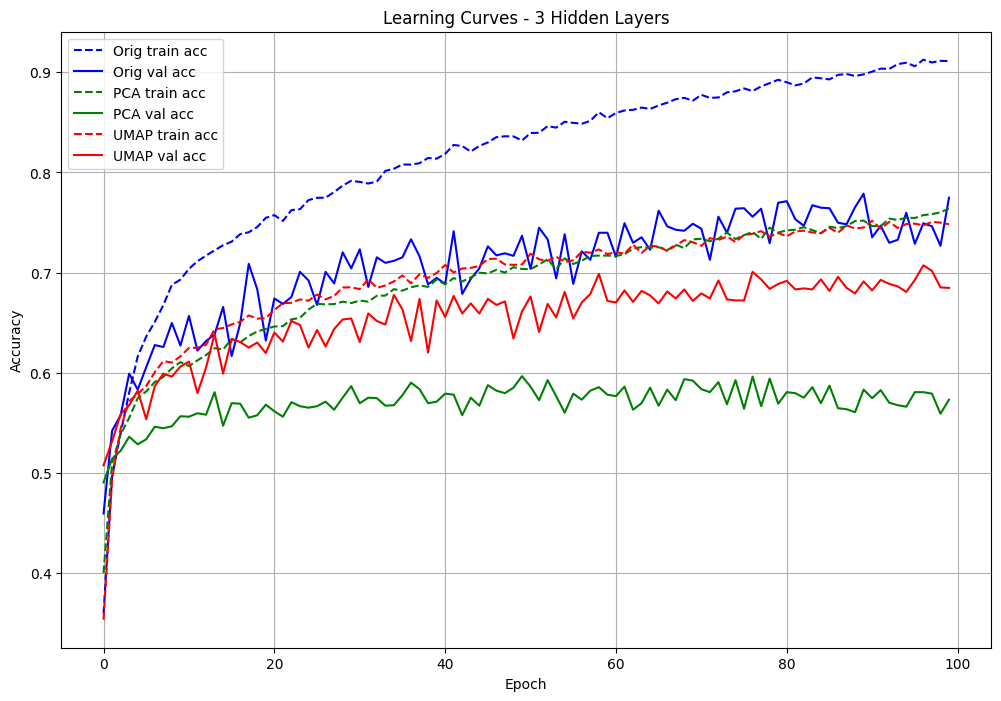

Run:  Orig  Total time:  55.8570601940155  Time per epoch:  0.5585706019401551
Run:  PCA  Total time:  81.5354151725769  Time per epoch:  0.8153541517257691
Run:  UMAP  Total time:  79.60329389572144  Time per epoch:  0.7960329389572144


In [45]:
# Plot learning curves
plt.figure(figsize=(12, 8))

colors = ['blue', 'green', 'red']
epochs = 100

times = []
for i, x_run in enumerate([[x_train_sc, x_test_sc, "Orig"], [x_pca, x_test_pca, "PCA"], [x_umap, x_test_umap, "UMAP"]]):
    start = time.time()
    x_tr = x_run[0]
    x_tst = x_run[1]
    label = x_run[2]
    # Create and compile the model
    model = create_model(input_shape=x_tr.shape[1:])

    # Train and evaluate the model
    history = train_and_evaluate(model, epochs, x_tr, y_encoded, x_tst, y_test_enc)
    end = time.time()
    times.append([end - start, (end - start) / epochs])

    # Plot learning curves
    plt.plot(history['accuracy'], label=label + " train acc", linestyle='--', color=colors[i])
    plt.plot(history['val_accuracy'], label=label + " val acc", color=colors[i])

# Add labels and legend
plt.title('Learning Curves - 3 Hidden Layers')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("pngs/gtzan/learning_curves_dr_new.png")
# Show the plot
plt.show()

for t, run in zip(times, ["Orig", "PCA", "UMAP"]):
    print("Run: ", run, " Total time: ", t[0], " Time per epoch: ", t[1])

In [44]:
# Fit KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(x_train_sc)
# Get distances to each cluster centroid
dist_train = kmeans.transform(x_train_sc)
dist_test = kmeans.transform(x_test_sc)

# Convert distances to probabilities
min_distances = np.min(dist_train, axis=1, keepdims=True)
probabilities = (min_distances / dist_train)**2
probabilities /= np.sum(probabilities, axis=1, keepdims=True)
kmeans_probs = probabilities

min_distances = np.min(dist_test, axis=1, keepdims=True)
probabilities = (min_distances / dist_test)**2
probabilities /= np.sum(probabilities, axis=1, keepdims=True)
kmeans_probs_test = probabilities

# Fit Gaussian Mixture Model (EM)
gmm = GaussianMixture(n_components=10, random_state=42)
gmm.fit(x_train_sc)
# Get cluster probabilities for Gaussian Mixture Model (EM)
gmm_probs = gmm.predict_proba(x_train_sc)
gmm_probs_test = gmm.predict_proba(x_test_sc)

Epoch 1/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2539 - loss: 2.1550 - val_accuracy: 0.4525 - val_loss: 1.6803
Epoch 2/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.4380 - loss: 1.6458 - val_accuracy: 0.4970 - val_loss: 1.4601
Epoch 3/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.4911 - loss: 1.4489 - val_accuracy: 0.5215 - val_loss: 1.3495
Epoch 4/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.5242 - loss: 1.3411 - val_accuracy: 0.5415 - val_loss: 1.2850
Epoch 5/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5505 - loss: 1.2633 - val_accuracy: 0.5626 - val_loss: 1.2455
Epoch 6/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.5717 - loss: 1.2061 - val_accuracy: 0.5836 - val_loss: 1.1924
Epoch 7/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.5853 - loss: 1.1736 - val_accuracy: 0.5981 - val_loss: 1.1689
Epoch 8/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.6159 - loss: 1.122

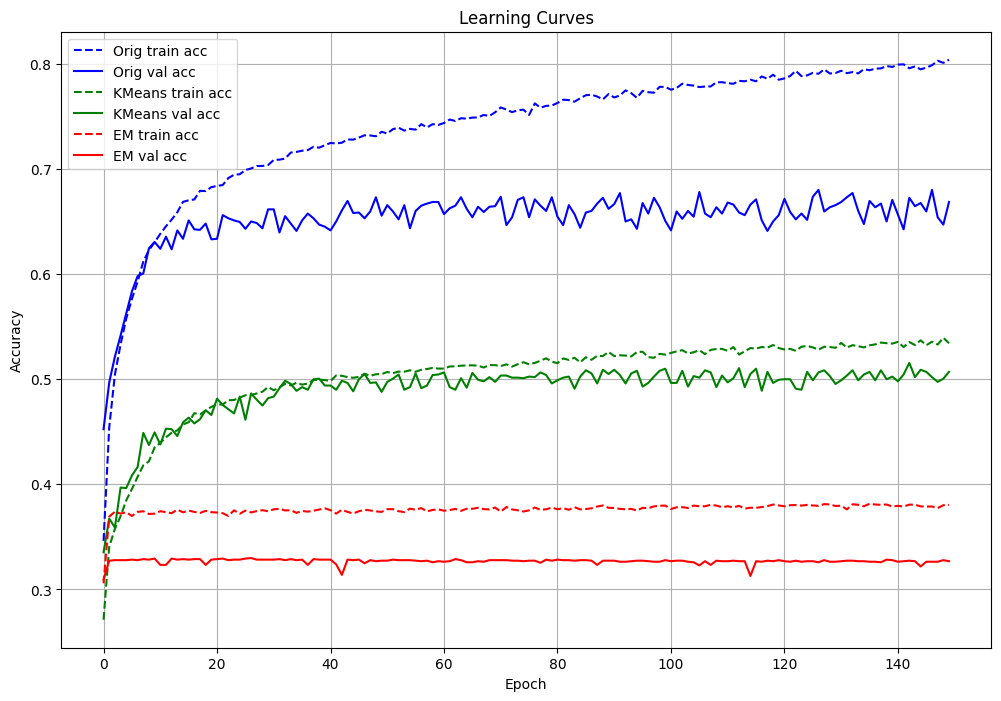

Run:  Orig  Total time:  45.082093238830566  Time per epoch:  0.30054728825887045
Run:  Kmeans  Total time:  94.07089447975159  Time per epoch:  0.6271392965316772
Run:  EM  Total time:  59.520042419433594  Time per epoch:  0.396800282796224


In [48]:
# Plot learning curves
plt.figure(figsize=(12, 8))

colors = ['blue', 'green', 'red']
epochs = 150
times = []

for i, x_run in enumerate([[x_train_sc, x_test_sc, "Orig"], [kmeans_probs, kmeans_probs_test, "KMeans"], [gmm_probs, gmm_probs_test, "EM"]]):
    start = time.time()
    x_tr = x_run[0]
    x_tst = x_run[1]
    label = x_run[2]
    # Create and compile the model
    model = create_model(input_shape=x_tr.shape[1:])

    # Train and evaluate the model
    history = train_and_evaluate(model, epochs, x_tr, y_encoded, x_tst, y_test_enc)
    end = time.time()
    times.append([end - start, (end - start) / epochs])

    # Plot learning curves
    plt.plot(history['accuracy'], label=label + " train acc", linestyle='--', color=colors[i])
    plt.plot(history['val_accuracy'], label=label + " val acc", color=colors[i])

# Add labels and legend
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("pngs/gtzan/learning_curves_clustering.png")
# Show the plot
plt.show()

for t, run in zip(times, ["Orig", "Kmeans", "EM"]):
    print("Run: ", run, " Total time: ", t[0], " Time per epoch: ", t[1])